# Visualize the Attention of the Models

In [ ]:
# transformer 
## 2020
path = "/nfs/home/sveng/logs/random_sharpe_transformer/11_06_2021/opt_a-transformer_l-sharpe_ty-2020_bs-128_lr-0.001_pa-25_gn-1_wl-63_ws-63_nl-2_dh-512_dr-0.1_dm-128_nh-4.p"

In [19]:
# conv_momentum
## 2020
path = "/nfs/home/sveng/logs/tmp/opt_a-conv_transformer_l-sharpe_ty-2000_bs-128_lr-0.001_pa-25_gn-0.5_wl-63_ws-63_nl-3_dh-12_dr-0.1_dm-20_nh-4_embAdd-projection_embPos-simple_embT-False_embID-True_ql-[3, 3, 3]_sparse-True.p"

In [15]:
import numpy as np
import pandas as pd
import pickle
import torch
from torch.utils.data import DataLoader
from libs.data_loader import BaseDataLoader, DataTypes
import matplotlib.pyplot as plt
import seaborn as sns

from libs.data_loader import BaseDataLoader, DataTypes
from libs.futures_dataset import FuturesDataset

## Load Model & Data

In [20]:
train_dict = pickle.load(open(path, 'rb'))
model = train_dict['model']
train_manager = train_dict['train_manager']

# --- ---

index_col = 0
step_size = 21
split_ratio_val = 0

base_loader = BaseDataLoader(
    filename=train_manager['args']['filename'], index_col=index_col, start_date=train_manager['args']['start_date'], end_date=train_manager['args']['end_date'], test_date=train_manager['args']['end_date'], lead_target=train_manager['args']['lead_target'], split_ratio_val=0)

dataset_train = FuturesDataset(
    base_loader, DataTypes.TRAIN, win_size=train_manager['args']['win_len'], tau=train_manager['args']['lead_target'], step=step_size, scaler=train_manager['args']['scaler'])
#dataset_test = FuturesDataset(
#    base_loader, DataTypes.TEST, win_size=train_manager['args']['win_len'], tau=train_manager['args']['lead_target'], step=step_size, scaler=train_manager['args']['scaler'])
train_dataloader = DataLoader(
    dataset_train, batch_size=train_manager['args']['batch_size'], shuffle=False)
#test_dataloader = DataLoader(
#    dataset_test, batch_size=train_manager['args']['batch_size'], shuffle=False)

> Load raw datset (futures_prop.csv)
> Filtered out series: 
> Winzorizing [3, 3, 3, 1, 1] values at:             [ZR_close, NR_close, ZO_close, ZP_close, BN_close] (threshold: 5)
> Calculate covariates
> No additional scaling used


## Plot Predictions

In [21]:
#attn_i = dataset_train.plot_example(90, model=model, loss_type=train_manager['loss_type'])

## Visualize Attention

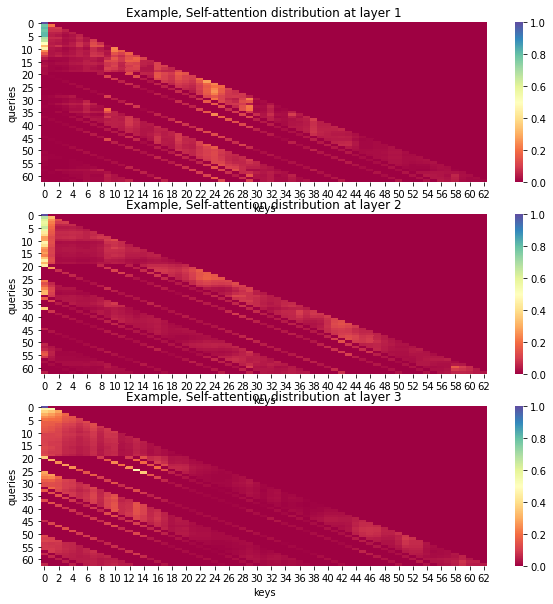

In [22]:
# Plot self-attention distribution for one example

id = 10
id_head = 0

attn = dataset_train.get_attention(id=id, model=model)
attn = attn[0] if isinstance(attn, list) else attn
attn = attn[0, :, :, :] # take first obs

# ---

n_layer_attn = attn.shape[0]
fig, axes = plt.subplots(n_layer_attn, 1, figsize=(10, 10))

for l in range(n_layer_attn):
    #mask = np.zeros_like(attn[0, :, :], dtype=np.bool)
    #mask[np.triu_indices_from(mask)] = True
    sns.heatmap(attn[l, id_head, :, :], ax=axes[l], cmap="Spectral")
    axes[l].set(xlabel="keys", ylabel="queries", title=f"Example, Self-attention distribution at layer {l+1}")

In [7]:
def plot_attention_line(model, id=None, data_iter=dataset_train, base_df=base_loader.df[DataTypes.TRAIN], step=2, n_color=5, layer=0, head=0):
    if id is None:
        # randomize
        sample_size = len(data_iter)
        id = int(np.random.uniform(0, sample_size))
    
    attn = data_iter.get_attention(id=id, model=model)
    inst = data_iter[id]['inst']

    # build df ----
    df_plot = pd.DataFrame({
        'prs': data_iter[id]['prs'][:, 0].squeeze().cpu().numpy(),
        'prs_lead': data_iter[id]['prs'][:, 1].squeeze().cpu().numpy(),
        'attn': attn[0, layer, head, -1, :],
        't': data_iter[id]['time']
    })
    #df_plot['t'] = range(df_plot.shape[0])
    df_plot['date'] = base_df.index[df_plot['t']]
    df_plot['t_group'] = pd.qcut(df_plot['t'], int(63/step), labels=False)
    df_plot['attn_mean'] = df_plot['attn'].groupby(df_plot['t_group']).transform('mean')
    df_plot['attn_group'] = pd.qcut(df_plot['attn_mean'], n_color, labels=False)

    # plot ----
    fig, ax = plt.subplots(1,1)
    cmap = plt.get_cmap(name='viridis', lut=n_color)
    for i in range(0, 63+1, step):
        # ... in segments ----
        group = df_plot.iloc[i:(i+step+1),:]
        attn_i = group.iloc[0, -1]
        color = cmap(attn_i)
        ax.plot(group['date'], group['prs'], color=color, markeredgewidth=1.5, zorder=0, marker=".")
        ax.plot(group['date'], group['prs'], color=color, linewidth=2.5, zorder=2)

    # prediction point
    # ... currently not support business date (!)
    next_date = df_plot['date'].iat[-1] + pd.Timedelta(1, 'D')
    ax.scatter(next_date, df_plot['prs_lead'].iat[-1], marker="x", color="red")

    # raw
    ax2 = ax.twinx()
    ax2.plot(df_plot['date'], df_plot['attn'], '--', zorder=1, color="black")

    # labels, ..
    ax.set_xlabel('t')
    ax.set_ylabel('price')
    ax2.set_ylabel('attention')
    ax.set_title(inst)
    ax.tick_params(axis='x', rotation=70)
    fig.show()

In [9]:
#plot_attention_line(model=model, data_iter=dataset_train, step=5, n_color=10)

## Regime identification Attention (Global)

In [10]:
def calc_bhattacharyya_coef(p, q):
    '''Calculates the Byattacharyya distance of two histograms.'''
    def normalize(h):
        return h / np.sum(h)
    return np.sum(np.sqrt(np.multiply(normalize(p), normalize(q))))


def calc_distance(p, q):
    """Distance measure according to Temporal Fusion Transformer"""
    return np.sqrt(1 - calc_bhattacharyya_coef(p, q))


def build_attention_df(data_iter, dataset, base_df, model, layer=1, head=1): 
    """Builds a dataframe with the last(*) self-attention query per window"""
    attn_dict = {}
    for _, batch in enumerate(data_iter):
        attn = dataset.get_attention(model=model, batch=batch)
        B, n_layer, H, _, _ = attn.shape
        
        attn_last = attn[:, :, :, -1, :]
        insts = batch['inst']
        time_steps = batch['time'].detach().cpu().numpy()
        
        for i in range(B):
            inst = insts[i]
            last_date = base_df.index[time_steps[i]][-1] # ?!
            if inst not in attn_dict:
                attn_dict[inst] = {}
            attn_dict[inst][last_date] = attn_last[i, (layer-1), (head-1), :]

    # to multiindex (inst, date) dataframe
    # ... pd expects touples
    attn_touple = {(outerKey, innerKey): values for outerKey, innerDict in attn_dict.items() for innerKey, values in innerDict.items()}
    df_attn = pd.DataFrame(attn_touple)
    return df_attn


def calculate_attn_dist_over_time(attn_df, inst=None):
    """Calculate the distance between attention distributions over time"""

    # average across instruments
    attn_df = attn_df.T.reset_index(drop=False)
    # level_0: inst
    # level_1: time

    if inst is None:
        attn_df = attn_df.groupby('level_1').mean() 
    else:
        attn_df = attn_df[attn_df['level_0'] == inst]
        attn_df.index = attn_df['level_1']
        attn_df = attn_df.iloc[:, 2:]
    
    attn_mean = attn_df.mean(axis=0)

    # calc distance per t ----
    dist_t = {}
    for t, date in enumerate(attn_df.index):
        dist_t[date] = calc_distance(attn_df.iloc[t,:], attn_mean)

    return pd.Series(dist_t)

# --- ---

global_attn_l1_h1 = df_global_attn_l1_h1 = build_attention_df(
    data_iter=train_dataloader, dataset=dataset_train,
    base_df=base_loader.df[DataTypes.TRAIN], model=model, layer=1, head=1)

## Positional Attention

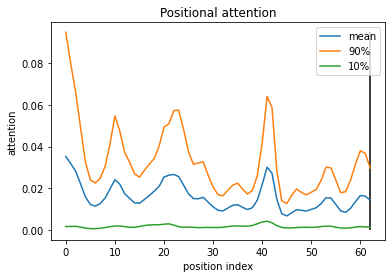

In [11]:
def plot_pos_attention(df):
    fig, ax = plt.subplots(1,1)
    ax.plot(range(df.shape[0]), df.mean(axis=1), label="mean")
    ax.plot(range(df.shape[0]), df.quantile(q=0.9, axis=1), label="90%")
    ax.plot(range(df.shape[0]), df.quantile(q=0.1,axis=1), label="10%")
    ax.vlines(df.shape[0]-1, ymin=0, ymax=np.max(df.quantile(q=0.9, axis=1)), color="black")

    ax.legend()
    ax.set(ylabel="attention", xlabel="position index", title="Positional attention")

plot_pos_attention(global_attn_l1_h1)

## Shift in Attention

<AxesSubplot:title={'center':'Global shift in attention'}, xlabel='time', ylabel='attention distance'>

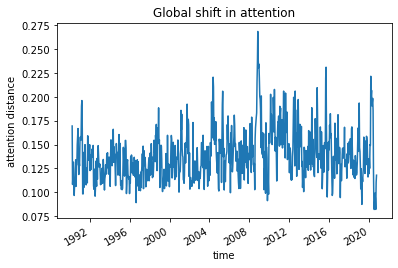

In [12]:
# Global: Plot the distance measure across all instruments over time

global_distance_l1_h1 = calculate_attn_dist_over_time(global_attn_l1_h1)

global_distance_l1_h1.plot(xlabel="time", ylabel="attention distance", title="Global shift in attention")

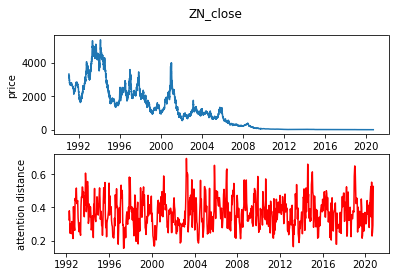

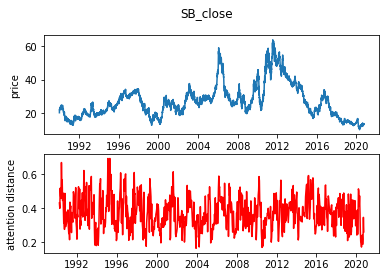

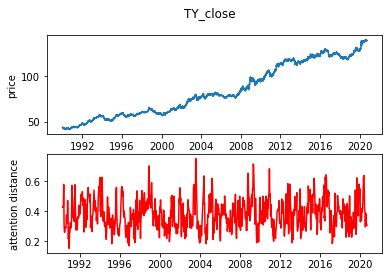

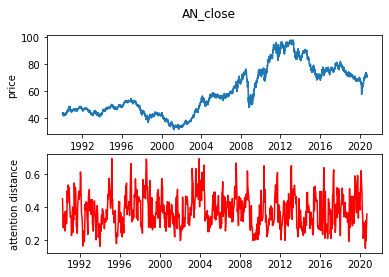

In [13]:
# Per instrument: Plot shift in attention distribution over time

def plot_attn_distance_per_inst(inst_label, base_df, df_attn):
    prs_inst = base_df[inst_label]['prs']
    dist_inst = calculate_attn_dist_over_time(df_attn, inst=inst_label)

    fig, axes = plt.subplots(2,1)
    fig.suptitle(inst)
    axes[0].plot(prs_inst.index, prs_inst.values)
    axes[0].set_ylabel("price")
    axes[1].plot(dist_inst.index, dist_inst.values, color="red")
    axes[1].set_ylabel("attention distance")

insts = ['ZN_close', 'SB_close', 'TY_close', 'AN_close']

for i, inst in enumerate(insts):
    plot_attn_distance_per_inst(inst_label=inst, base_df=base_loader.df[DataTypes.TRAIN], df_attn=global_attn_l1_h1)


# Entity Embedding

In [11]:
# for conv_momentum

model.embed_type



'fixed'